(658, 570, 3)


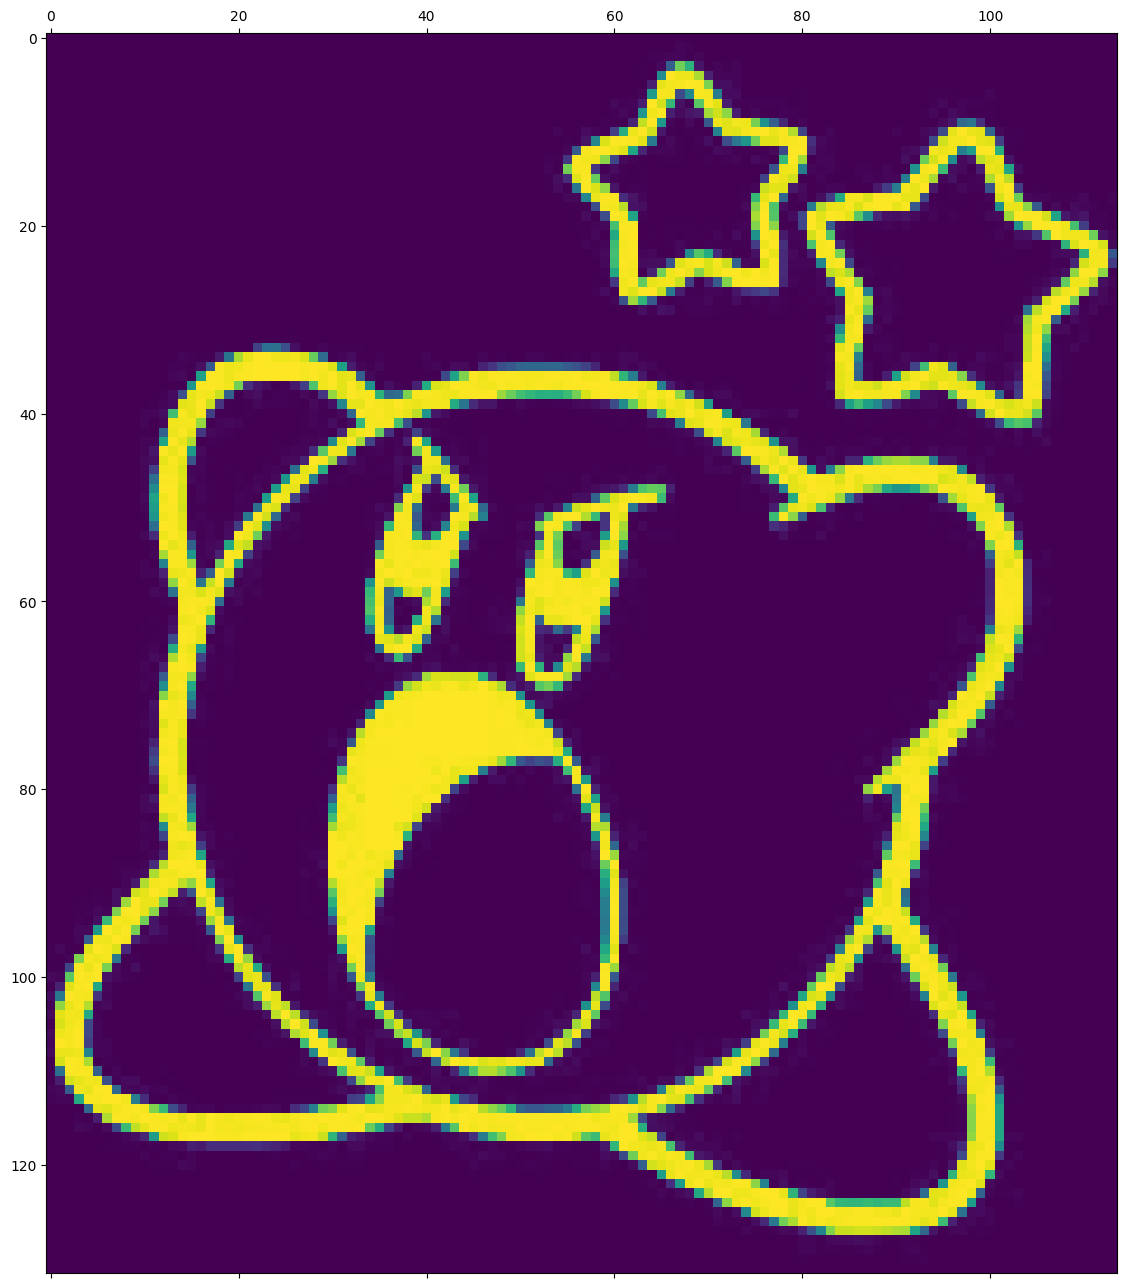

In [1]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.transform import probabilistic_hough_line
import random 

plt.rcParams['figure.figsize'] = [20, 20]

# Load image"
image_path = "/Users/nshelton/Pictures/plot_raster/gundam_title.png"
image_path = "/Users/nshelton/Pictures/plot_raster/kirby.jpg"
# image_path = "/Users/nshelton/Pictures/akira.jpeg"
# image_path = "/Users/nshelton/Pictures/akira.jpeg"

# image_path = "/Users/nshelton/Pictures/plot_raster/stairs.png"

image = cv2.imread(image_path)
print(image.shape)

# image[:,:,1] = image[:,:,0]
# image[:,:,2] = image[:,:,0]

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
# _ , filtered =  cv2.threshold(image_gray, 150, 255, cv2.THRESH_BINARY_INV)


filtered = image_gray

# sigma = 2
# min_canny = 2
# max_canny = 100
# filtered = canny(image_gray, sigma, min_canny, max_canny).astype(np.uint8) * 255


filtered = 255 - filtered

# filtered = filtered[50:150, 50:150]
# filtered = filtered[950:1000, 1150:1200]
cv2.imwrite("filtered.png", filtered)

filtered = cv2.resize(filtered, (-1,-1), fx = 0.2, fy = 0.2)


plt.matshow(filtered)

base_img = filtered


In [2]:
# base_img = np.zeros((50,50, 1), np.uint8)
# base_img = cv2.circle(base_img, (25,25), 20, 255, 1)

base_img = filtered

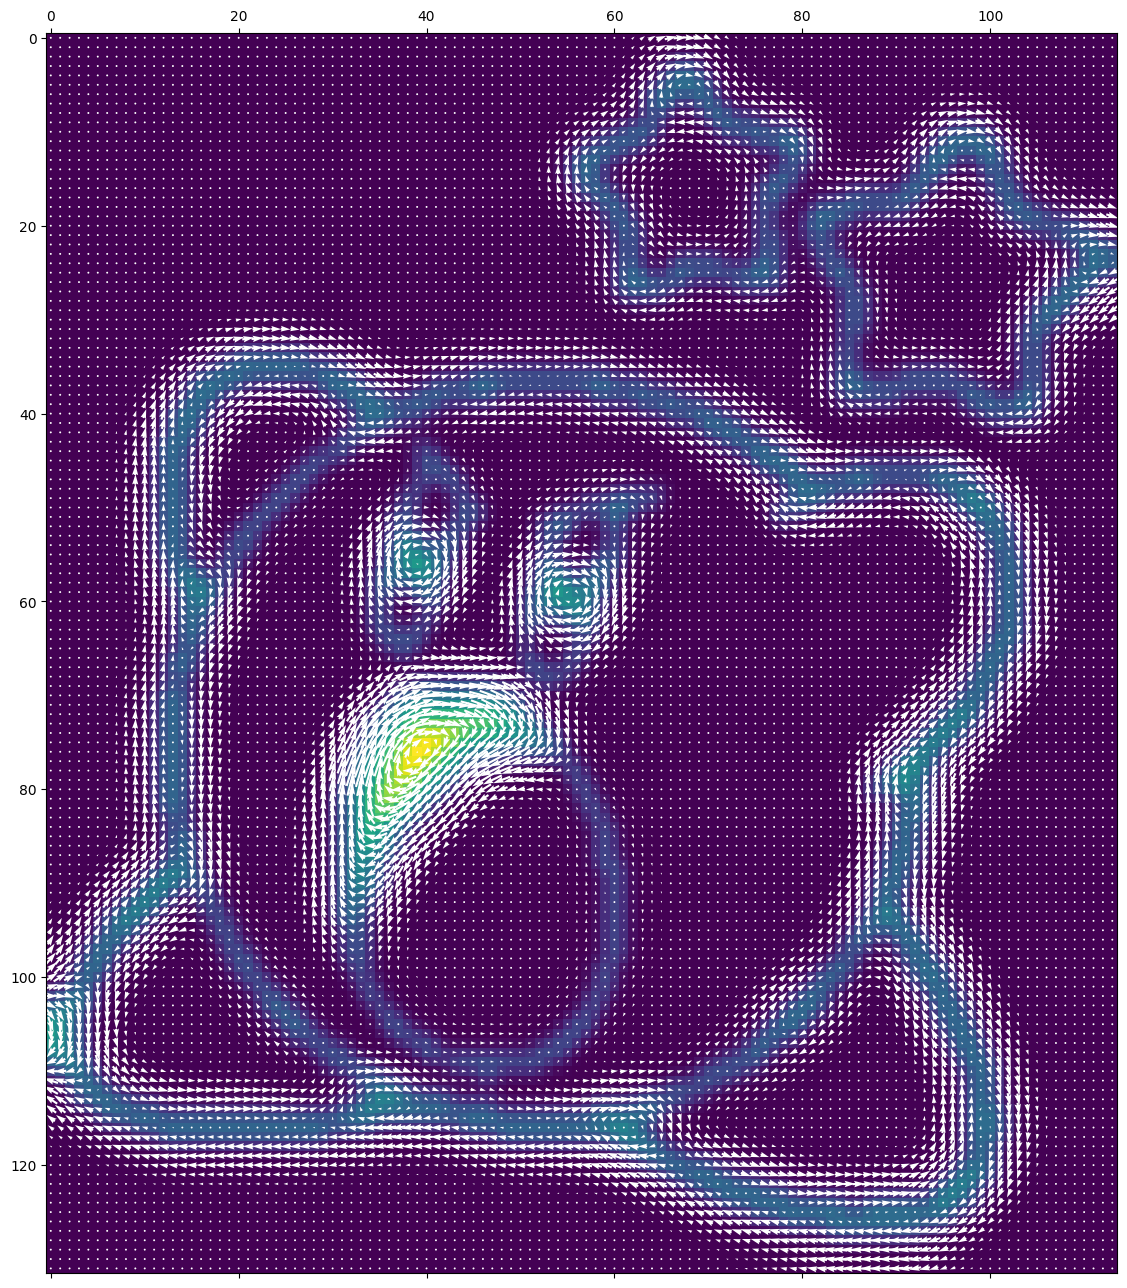

In [3]:
from scipy.ndimage import median_filter

erode_stack = base_img.copy()

erode_stack = cv2.GaussianBlur(erode_stack, (3,3), -1)

erode_stack = cv2.adaptiveThreshold(erode_stack, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  cv2.THRESH_BINARY, 101, -10)
# plt.matshow(erode_stack, cmap="turbo")

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

distance_field = []
for i in range(10) : 
    distance_field.append(erode_stack)
    if erode_stack.sum() == 0 : break
    erode_stack = cv2.erode(erode_stack, kernel)

distance_field =  (np.array(distance_field) > 0).sum(axis=0).astype(np.float32)

for i in range(1):
    distance_field = cv2.GaussianBlur(distance_field, (3,3), -1)

# distance_field = base_img
# plt.matshow(distance_field, cmap="turbo")

scale = 1
delta = 0
ddepth = cv2.CV_16S

grad_x = cv2.Sobel(distance_field, ddepth, 1, 0, ksize=1, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT).astype(np.float32)
grad_y = cv2.Sobel(distance_field, ddepth, 0, 1, ksize=1, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT).astype(np.float32)

flow_field = np.dstack([grad_x, grad_y])

# for _ in range(2):
    # flow_field = cv2.GaussianBlur(flow_field, (3,3), 0)

for _ in range(10):
    flow_field = cv2.GaussianBlur(flow_field, (3,3), -1)

mag = np.linalg.norm(flow_field, axis = 2)
angles = np.arctan2(flow_field[:,:,1], flow_field[:,:,0]) 

# angles = np.mod(angles, np.pi) 
angles = median_filter(angles, 3)


flow_field = np.stack([np.cos(angles), np.sin(angles) ], axis=2) * mag[:,:,np.newaxis]

for _ in range(2):
    flow_field = cv2.GaussianBlur(flow_field, (3,3), 0)

X, Y = np.meshgrid(range(grad_x.shape[1]), range(grad_x.shape[0]))
plt.matshow(distance_field, cmap="viridis")
plt.quiver(X,Y, flow_field[:,:,1], flow_field[:,:,0], color="white", pivot="mid", width = 0.002, scale =50)
plt.show()


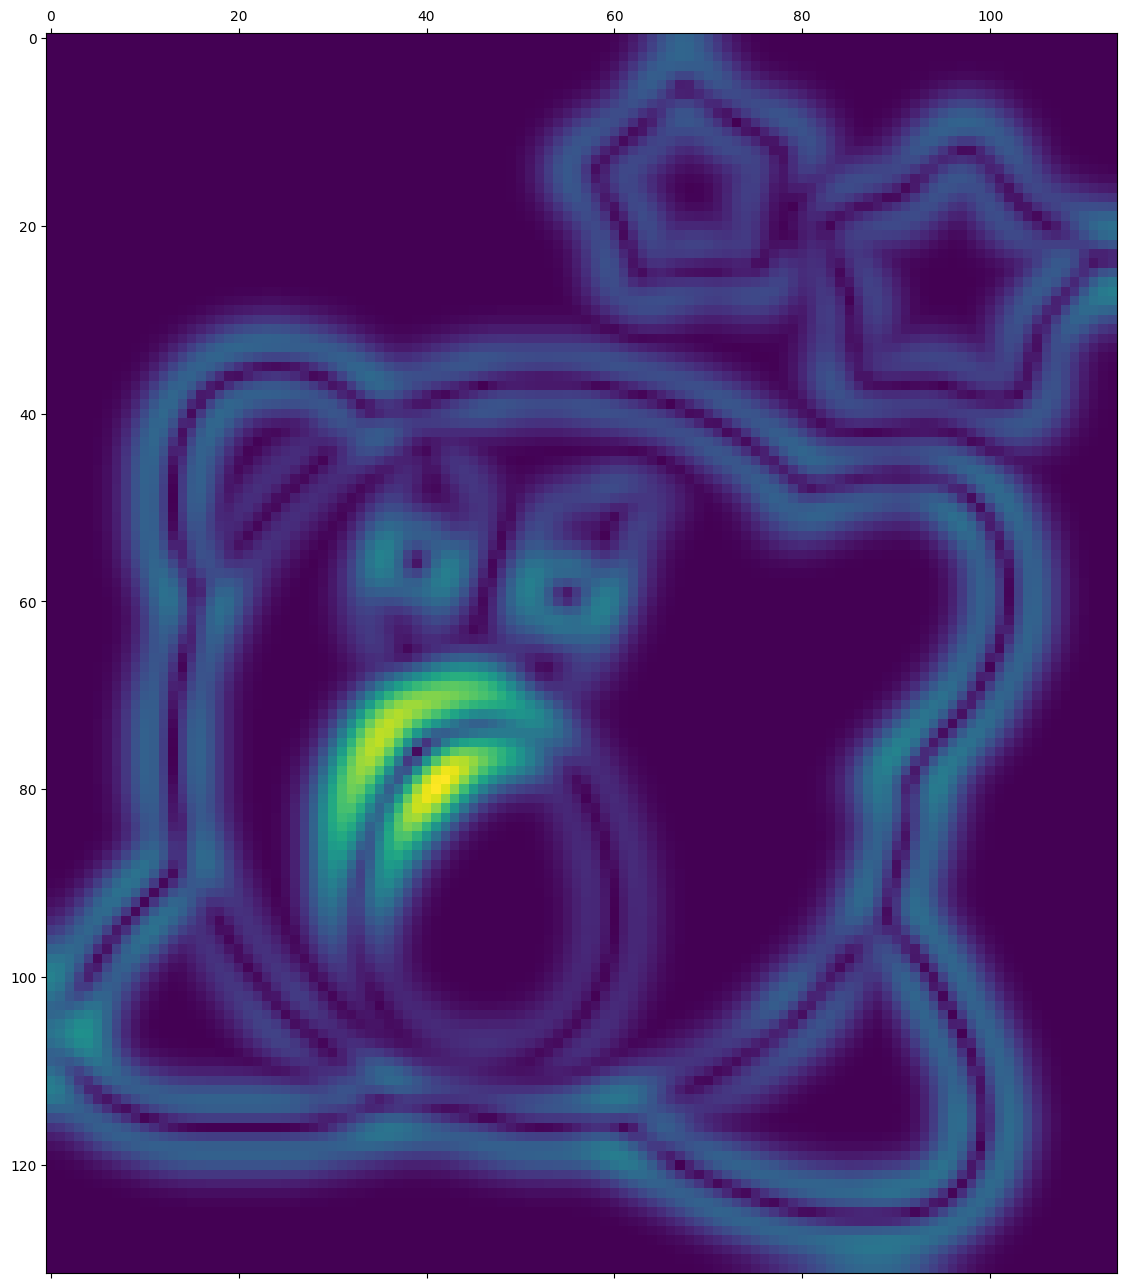

In [4]:
plt.matshow(mag)

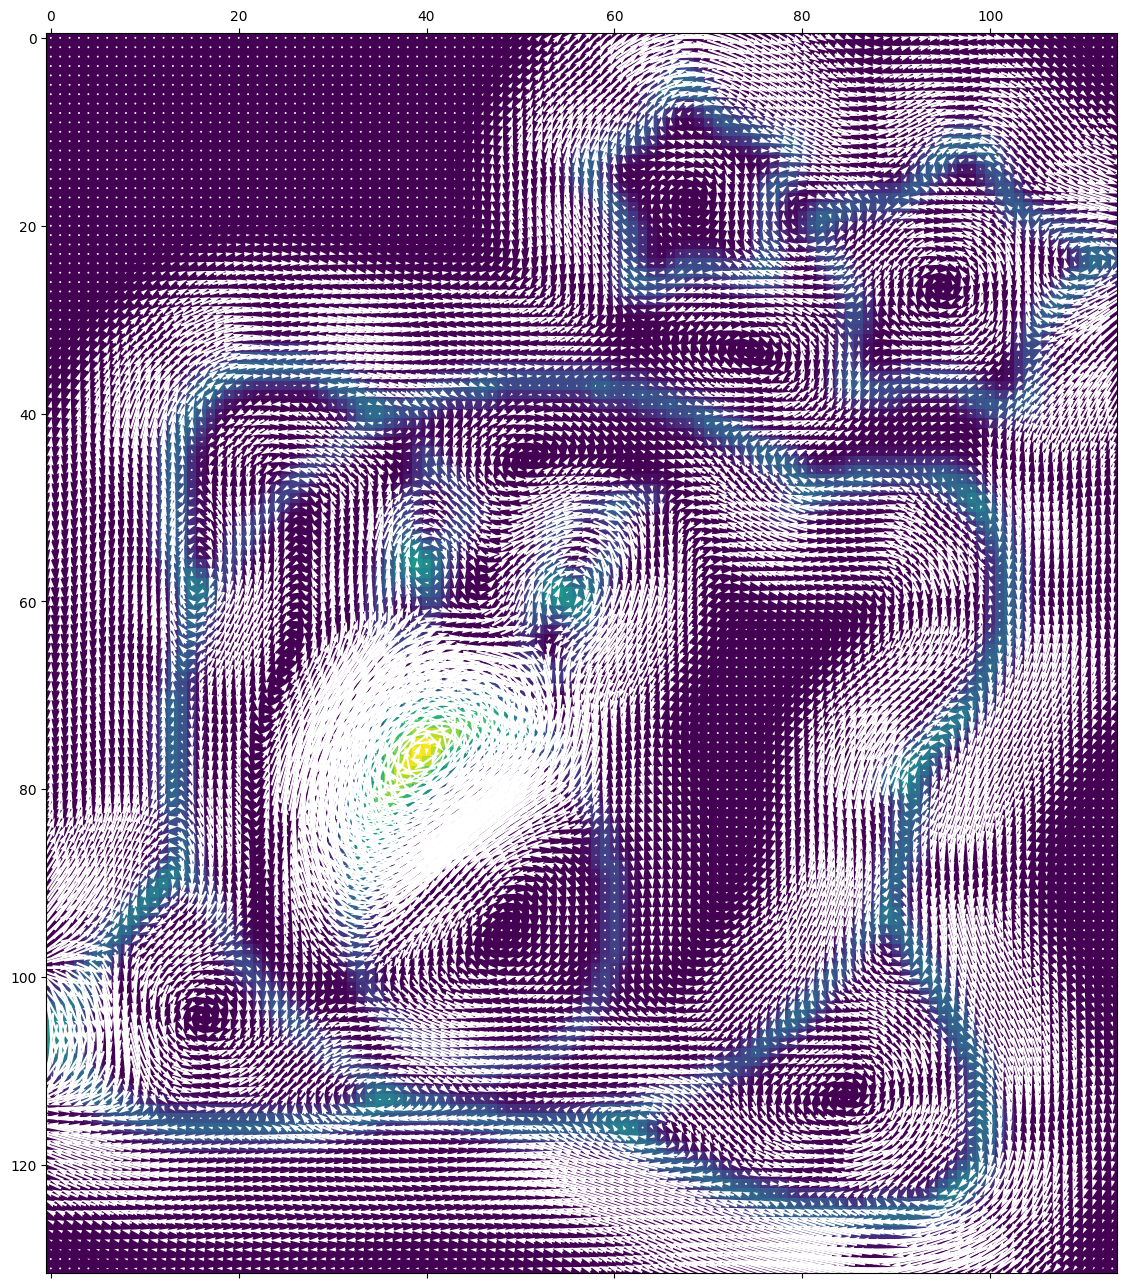

In [8]:
from scipy.ndimage import gaussian_filter

# Convert to complex numbers
complex_angles = np.exp(1j * angles) * mag

real_blurred = gaussian_filter(np.real(complex_angles), sigma=5)
imag_blurred = gaussian_filter(np.imag(complex_angles), sigma=5)

blurred_complex = real_blurred + 1j * imag_blurred
blurred_angles_radians = np.angle(blurred_complex)

X, Y = np.meshgrid(range(grad_x.shape[1]), range(grad_x.shape[0]))

plt.matshow(distance_field, cmap="viridis")

plt.quiver(X,Y, np.imag(blurred_complex), np.real(blurred_complex), 
           color="white", pivot="mid", width = 0.002, scale =5)
plt.show()


# flow_field = np.dstack([np.imag(blurred_complex), np.real(blurred_complex)])

# print(flow_field.shape)

In [9]:
angkes = blurred_angles_radians

levels = 2

scale = (levels / 255.0)
posterize = base_img.astype(np.float32) * scale
posterize = posterize.astype(np.uint8)

layers = []
while posterize.sum() > 0:
    layer = posterize > 0
    layers.append(layer)
    posterize -= layer

from tqdm import tqdm 
from pathUtils import *


def merge_all(paths, merge_threshold=1):

    # for i in tqdm(range(len(paths))):
    for i in range(len(paths)):
        len_before = len(paths)
        paths = merge_one_path_kd(paths, merge_threshold)
        if len_before == len(paths):
            break
    return paths


def numpy_to_list(array):
    if isinstance(array, np.ndarray):
        return numpy_to_list(array.tolist())
    if isinstance(array, list) :
        return [numpy_to_list(item) for item in array]
    else:
        return array


def rotate_points(points, angle_radians):
    rotation_matrix = np.array(
        [
            [np.cos(angle_radians), -np.sin(angle_radians)],
            [np.sin(angle_radians), np.cos(angle_radians)],
        ]
    )
    rotated_points = np.dot(points, rotation_matrix.T)
    return rotated_points


paths = []

# dir = np.array([[-0.5, 0], [0.5, 0]])
dir = np.array([[ 0, - 0.5], [0, 0.5]])
for i in range(1):
    l = layers[i]
    layer_paths = []

    for r in tqdm(range(l.shape[0])):
        for c in range(l.shape[1]):
            if l[r, c]:
                angle = angles[r,c] + np.pi/2
                mag = 1
                flow_dir = rotate_points(dir, angle + np.pi/2) * mag
                new_path = [
                    [c + flow_dir[0][0], r + flow_dir[0][1]],
                    [c + flow_dir[1][0], r + flow_dir[1][1]],
                ]
                # paths = add_path_with_merge(paths, new_path, add=True, threshold = 1)
                
                paths.append(new_path)
        paths = merge_all(paths, merge_threshold=0.1)
        # paths = simplify_all(paths, 0.01) 
        # paths = numpy_to_list(paths)

    paths += layer_paths
    # dir = rotate_points(dir, 90)
    # dir += 0.3


print(paths)
path_list = [[p for p in path] for path in paths if len(path) > 1]
RENDER_SCALE = 1
render_img = plotPaths(path_list, RENDER_SCALE)
cv2.imwrite("render.png", render_img)


100%|██████████| 132/132 [00:11<00:00, 11.27it/s]


[[[66.50610773743011, 3.0779129833442616], [67.49389226256989, 2.9220870166557384], [67.50856231463561, 2.9078642229983727], [68.49143768536439, 3.0921357770016273]], [[65.6079802701234, 4.31035549195638], [66.3920197298766, 3.6896445080436204]], [[66.51633373893428, 4.1267554649974025], [67.48366626106572, 3.8732445350025975], [67.52090532522907, 3.8569325592382158], [68.47909467477093, 4.143067440761784]], [[68.61190065335863, 3.684755813477002], [69.38809934664137, 4.315244186522998]], [[64.79586103808012, 5.456428838074759], [65.20413896191988, 4.543571161925241]], [[65.76679509110495, 5.4422843773719025], [66.23320490889505, 4.5577156226280975]], [[66.6079802701234, 5.31035549195638], [67.3920197298766, 4.68964450804362]], [[67.51633373893428, 5.1267554649974025], [68.48366626106572, 4.8732445350025975]], [[68.61190065335863, 4.684755813477002], [69.38809934664137, 5.315244186522998]], [[69.74452263237947, 4.570196190531444], [70.25547736762053, 5.429803809468556]], [[63.832765040

True

In [7]:


path_list = [[p for p in path] for path in paths if len(path) > 1]

print(len(paths))
print(len(path_list))

merge_threshold = 2

for i in tqdm(range(len(path_list))):
    len_before = len(path_list)
    path_list = merge_one_path_kd(path_list, merge_threshold)
    if len_before == len(path_list):
        break

def getPathLength(path):
    length = 0
    for i in range(len(path) - 1):
        length += np.linalg.norm(path[i] - path[i+1])
    return length

path_list = close_loops(path_list, threshold=5)
path_list  = [np.array(path) for path in path_list]

path_list = [path for path in path_list if getPathLength(path) > 2]
path_list = smooth_all_2(path_list, 0.01)
path_list = simplify_all(path_list, 0.001)
path_list = smooth_all_2(path_list, 0.5)
path_list = simplify_all(path_list, 0.1)

RENDER_SCALE = 1
render_img = plotPaths(path_list, RENDER_SCALE)
cv2.imwrite("render.png", render_img)

NameError: name 'paths' is not defined

In [ ]:
path_list = smooth_all_2(path_list, 0.5)
# path_list = simplify_all(path_list, 0.5)

RENDER_SCALE = 1
render_img = plotPaths(path_list, RENDER_SCALE)
cv2.imwrite("render.png", render_img)

True